<a href="https://colab.research.google.com/github/AbdulHakkam/SDGP/blob/ML-Model/Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

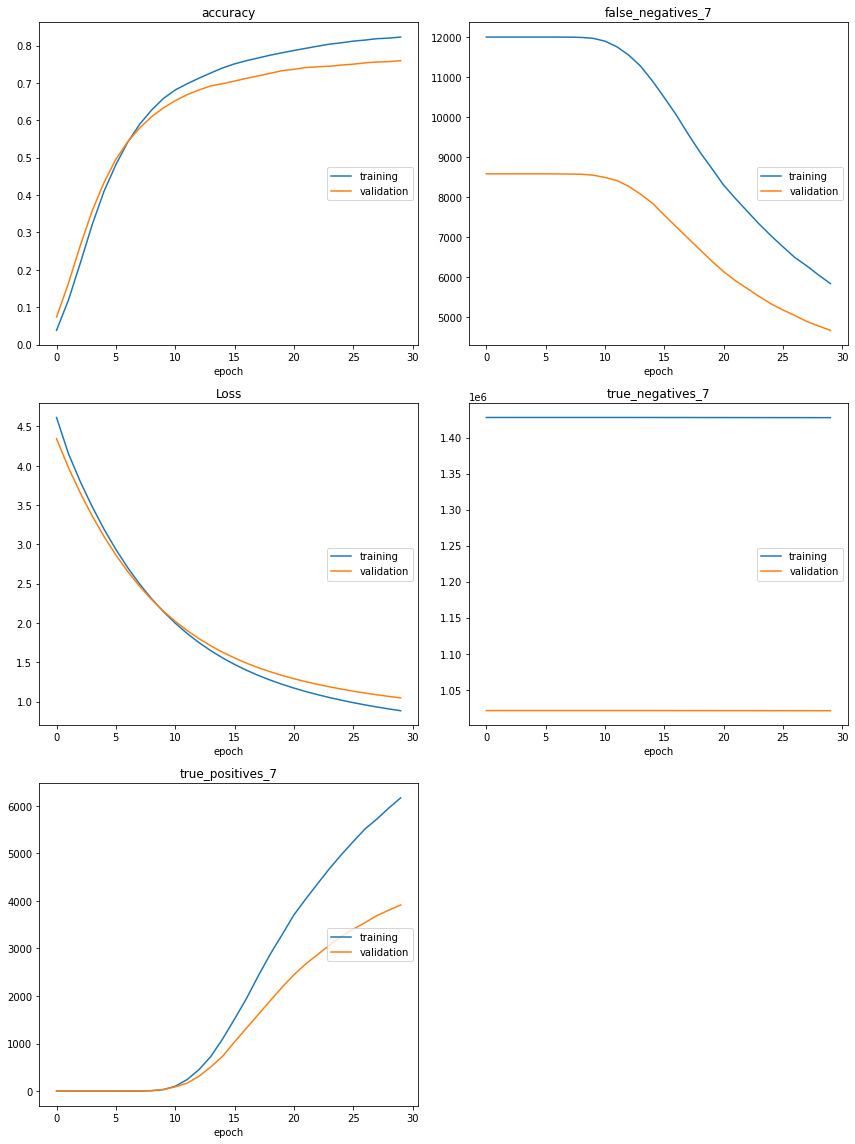

accuracy
	training         	 (min:    0.038, max:    0.823, cur:    0.823)
	validation       	 (min:    0.073, max:    0.760, cur:    0.760)
false_negatives_7
	training         	 (min: 5835.000, max: 12000.000, cur: 5835.000)
	validation       	 (min: 4667.000, max: 8580.000, cur: 4667.000)
Loss
	training         	 (min:    0.883, max:    4.614, cur:    0.883)
	validation       	 (min:    1.046, max:    4.343, cur:    1.046)
true_negatives_7
	training         	 (min: 1427753.000, max: 1428000.000, cur: 1427753.000)
	validation       	 (min: 1020809.000, max: 1021020.000, cur: 1020809.000)
true_positives_7
	training         	 (min:    0.000, max: 6165.000, cur: 6165.000)
	validation       	 (min:    0.000, max: 3913.000, cur: 3913.000)
375/375 [==============================] - 94s 241ms/step - loss: 0.8831 - accuracy: 0.8228 - true_negatives_7: 1427753.0000 - false_negatives_7: 5835.0000 - true_positives_7: 6165.0000 - val_loss: 1.0465 - val_accuracy: 0.7596 - val_true_negatives_7: 102

In [10]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import cv2 as cv
import pandas as pd
import sklearn.metrics as metrics
from tensorflow import keras

!pip install livelossplot
from livelossplot import PlotLossesKeras


(ds_train,ds_test),info = tfds.load('StanfordDogs', split=["train","test"], with_info=True,as_supervised=True)  #retreiving dataset



def preprocess(image,label):                                                   #preprocess dataset before training by converting type and resizing it to 224,224,3

    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, (244,244), method='nearest')
  
    label = tf.one_hot(label,120)

    return image, label
def prepare(dataset, batch_size=None):                                         #prepares the dataset for training by preprocessing,shuffling and then prefetching the data                       
    ds = dataset.map(preprocess, num_parallel_calls=4)
    ds = ds.shuffle(buffer_size=1000)
    if batch_size:
      ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

  



ds_train = prepare(ds_train,batch_size=32)
ds_test =prepare(ds_test,batch_size=32)



IMG_SHAPE=(244,244,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(120, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adamax(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy',tf.keras.metrics.TrueNegatives(),tf.keras.metrics.FalseNegatives(),tf.keras.metrics.TruePositives()]
              )

history = model.fit(ds_train,epochs=30,validation_data=ds_test,callbacks=[PlotLossesKeras()])









